## Protein Tokenization Analysis

This notebook will compare tokenization strategies used to classify T cell phenotype strings according to their known (but withheld) subtype.

In [1]:
import pandas as pd
import numpy as np
import warnings
import tqdm
import plotnine as pn
from tcre.env import *

In [2]:
path = osp.join(RESULTS_DATA_DIR, 'protein-tokenization', 'dataset.pkl')
df = pd.read_pickle(path)
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2780 entries, 0 to 2779
Data columns (total 8 columns):
id                2780 non-null object
start_wrd         2780 non-null int64
end_wrd           2780 non-null int64
text              2780 non-null object
cell_type         2780 non-null object
cell_type_text    2780 non-null object
ptkn              2780 non-null object
clean_text        2780 non-null object
dtypes: int64(2), object(6)
memory usage: 173.8+ KB


In [3]:
df.head()

,id,start_wrd,end_wrd,text,cell_type,cell_type_text,ptkn,clean_text
0,PMC1555646,196,200,human CD4+CD25+Foxp3+ Tregs,Treg,Tregs,"[human, CD4⁺(+), CD25⁺(+), Foxp3⁺(+)]",human CD4+CD25+Foxp3+
1,PMC1867380,5134,5141,CD4+CD25+FoxP3+ IL-10–producing natural T regu...,nTreg,natural T regulatory,"[CD4⁺(+), CD25⁺(+), FoxP3⁺(+), IL-10⁻(–), prod...",CD4+CD25+FoxP3+ IL-10–producing cells
2,PMC1939810,6249,6254,CD4+CD25highCD62L−Foxp3+ regulatory T cells,Treg,regulatory T,"[CD4⁺(+), CD25⁺(high), CD62L⁻(−), Foxp3⁺(+), c...",CD4+CD25highCD62L−Foxp3+ cells
3,PMC1940266,816,821,CD4+CD25+Foxp3+ regulatory T cells,Treg,regulatory T,"[CD4⁺(+), CD25⁺(+), Foxp3⁺(+), cells]",CD4+CD25+Foxp3+ cells
4,PMC1945037,247,254,CD4+ CD25high FoxP3high regulatory T cells,Treg,regulatory T,"[CD4⁺(+), CD25⁺(high), FoxP3⁺(high), cells]",CD4+ CD25high FoxP3high cells


In [4]:
from gensim.models import KeyedVectors
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message='.*')
    w2v = KeyedVectors.load_word2vec_format(W2V_MODEL_01, binary=True, limit=500000)

In [5]:
w2v.vectors.shape

(500000, 200)

In [6]:
from tcre import integration
nlp = integration.get_scispacy_pipeline()
text = 'CD4+CD45RA+CD45RO-4-1BB-CD62L+++CCR7loCD127posCD27positiveCD28hiCD95+TNF-α-CD122+'
for t in nlp(text):
    print(t)

CD4+CD45RA+CD45RO-4
-
1BB-CD62L+++CCR7loCD127posCD27positiveCD28hiCD95+TNF-α-CD122
+


In [79]:
def get_features(df, w2v, nlp, use_ptkn=False):
    
    def get_tokens(r):
        if use_ptkn:
            tkns = [((t.token_text or '') + (t.sign_text or '')) for t in r['ptkn']]
        else:
            tkns = list(nlp(r['clean_text']))
        return tkns
            
        
    oov = np.zeros(w2v.vectors.shape[1], dtype=w2v.vectors.dtype)
    def get_vector(w):
        return w2v.get_vector(w) if w in w2v else oov
        
    V = pd.Series([
        np.stack([get_vector(t) for t in get_tokens(r)])
        for i, r in df.iterrows()
    ], index=df.index)
    X = pd.DataFrame([
        V[i].sum(axis=0) for i in range(len(V))], 
        index=df.index)
    y = df['cell_type']
    return V, X, y

In [80]:
V, X, y = get_features(df, w2v, nlp, use_ptkn=True)

In [81]:
X.shape, y.shape

((2780, 200), (2780,))

In [82]:
y.value_counts().sort_values()

iTreg      10
Tscm       13
TEMRA      28
MAIT       29
Treg1      37
γδT        39
nTreg      40
Th2        46
TEM        71
TCM        73
NKT        75
Th1        78
Th17      144
Tfh       352
Treg     1745
Name: cell_type, dtype: int64

In [83]:
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score

In [94]:
ests = {
    'xgb': XGBClassifier(random_state=TCRE_SEED),
    'gbr': GradientBoostingClassifier(random_state=TCRE_SEED),
    'ridge': RidgeClassifierCV(normalize=True),
    'mlp': Pipeline([
        ('scale', StandardScaler()), 
        ('est', MLPClassifier(hidden_layer_sizes=(15,), random_state=TCRE_SEED, max_iter=2000))
    ]),
    'svc': Pipeline([
        ('scale', StandardScaler()), 
        ('est', GridSearchCV(SVC(random_state=TCRE_SEED, gamma='auto'), {'C': [.01, .1, .5, 1., 5.]}))
    ]),
    'rnd-strat': DummyClassifier(strategy='stratified', random_state=TCRE_SEED),
    'rnd-mfreq': DummyClassifier(strategy='most_frequent', random_state=TCRE_SEED),
    'rnd-runif': DummyClassifier(strategy='uniform', random_state=TCRE_SEED),
}

In [ ]:
dfr = []

def get_scores(y_true, y_pred):
    return {
        'micro-f1': f1_score(y_true, y_pred, average='micro'),
        'macro-f1': f1_score(y_true, y_pred, average='macro'),
        'accuracy': accuracy_score(y_true, y_pred)
    }
    
for k in ests.keys():
    print(f'Fitting {k} ...')
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=TCRE_SEED)
    for i, (train, test) in tqdm.tqdm(list(enumerate(cv.split(X, y)))):
        X_train, y_train = X.iloc[train], y.iloc[train]
        X_test, y_test = X.iloc[test], y.iloc[test]
        est = ests[k]
        est.fit(X_train, y_train)
        y_pred = est.predict(X_test)
        dfr.append({**dict(est=est, est_name=k, fold=i, y_true=y_test, y_pred=y_pred), **get_scores(y_test, y_pred)})
    print('Done')

dfr = pd.DataFrame(dfr)
dfr.head()


  0%|          | 0/10 [00:00<?, ?it/s]

Fitting xgb ...


In [87]:
dfs = (
    dfr
    .drop(['est', 'y_pred', 'y_true'], axis=1)
    .set_index(['est_name', 'fold'])
    .rename_axis('metric', axis='columns').stack().rename('value')
    .reset_index()
)
dfs.head()

,est_name,fold,metric,value
0,xgb,0,accuracy,0.818508
1,xgb,0,macro-f1,0.531433
2,xgb,0,micro-f1,0.818508
3,xgb,1,accuracy,0.821068
4,xgb,1,macro-f1,0.500637


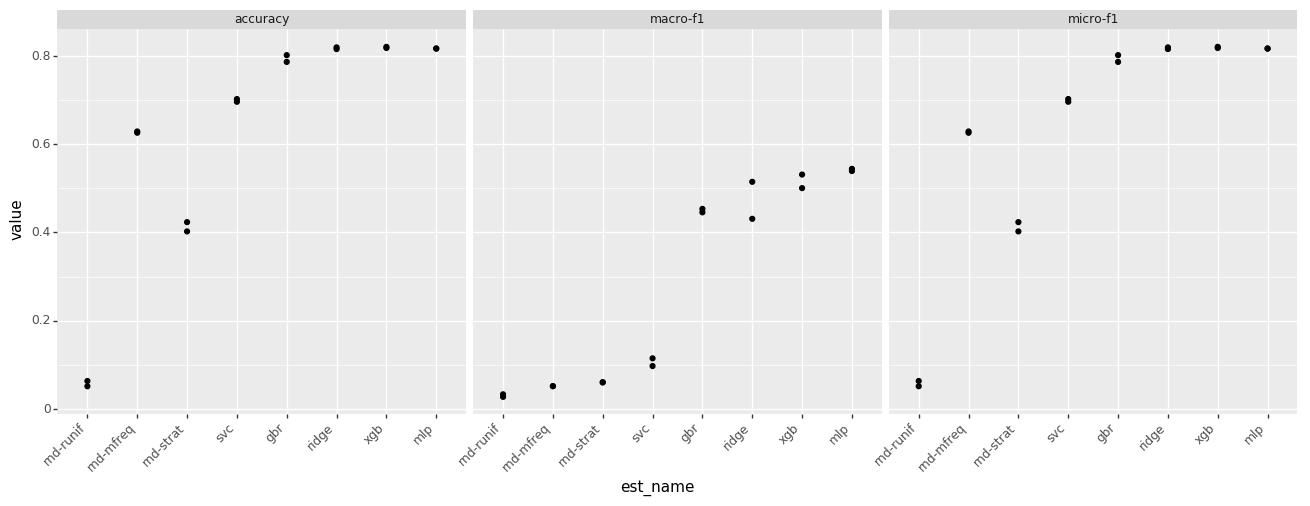

<ggplot: (8735202725608)>

In [93]:
(
    pn.ggplot(
        dfs
            .assign(est_name=lambda df: pd.Categorical(
                df['est_name'], ordered=True, 
                categories=df.groupby(['est_name', 'metric'])['value'].mean().unstack()['macro-f1'].sort_values().index
            ))
        , 
        pn.aes(x='est_name', y='value')
    ) + 
    pn.geom_point() + 
    pn.facet_wrap('~ metric') + 
    pn.theme(figure_size=(16, 5), axis_text_x=pn.element_text(rotation=45, hjust=1))
)